In [1]:
from datascience import create_pipeline
import Linreg
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# BRIEF PROJECT

# Get Dataframe

In [2]:
df = pd.read_csv('games_data.csv', encoding = 'unicode_escape', low_memory=False, index_col='id').drop_duplicates()
df.head(10)

,title,release_date,developer,publisher,genres,multiplayer_or_singleplayer,price,dc_price,overall_review,detailed_review,reviews,percent_positive,win_support,mac_support,lin_support
id,,,,,,,,,,,,,,,
0,Counter-Strike: Global Offensive,2012-08-21,Valve;Hidden Path Entertainment,Valve,Action;Free to Play,Multi-player;Steam Achievements;Full controlle...,Free to play,Free to play,Positive,Very Positive,6774812,88%,1,1.0,1.0
1,Dota 2,2013-07-09,Valve,Valve,Action;Free to Play;Strategy,Multi-player;Co-op;Steam Trading Cards;Steam W...,Free to play,Free to play,Positive,Very Positive,1885261,82%,1,1.0,1.0
2,"Warhammer 40,000: Darktide",NaN,NaN,NaN,NaN,NaN,"2,199","2,199",Positive,Mostly Positive,26092,72%,1,0.0,0.0
3,Call of Duty®: Modern Warfare® II,NaN,NaN,NaN,NaN,NaN,"4,999","4,999",Mixed,Mixed,215969,64%,1,0.0,0.0
4,Apex Legends,NaN,NaN,NaN,NaN,NaN,Free to play,Free to play,Positive,Very Positive,539297,85%,1,0.0,0.0
5,PUBG: BATTLEGROUNDS,NaN,NaN,NaN,NaN,NaN,Free to play,Free to play,Mixed,Mixed,2109992,56%,1,0.0,0.0
6,NARAKA: BLADEPOINT,NaN,NaN,NaN,NaN,NaN,"1,199","1,199",Positive,Mostly Positive,130245,73%,1,0.0,0.0
7,Dead by Daylight,2016-06-14,Behaviour Digital Inc.,Behaviour Digital Inc.,Action,Multi-player;Online Multi-Player;Co-op;Online ...,749,749,Positive,Very Positive,453698,81%,1,0.0,0.0
8,Warframe,2013-03-25,Digital Extremes,Digital Extremes,Action;Free to Play,Single-player;Multi-player;Co-op;Steam Trading...,Free to play,Free to play,Positive,Very Positive,512887,87%,1,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66923 entries, 0 to 73343
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title                        66922 non-null  object 
 1   release_date                 22774 non-null  object 
 2   developer                    22774 non-null  object 
 3   publisher                    22774 non-null  object 
 4   genres                       22774 non-null  object 
 5   multiplayer_or_singleplayer  22774 non-null  object 
 6   price                        66921 non-null  object 
 7   dc_price                     66921 non-null  object 
 8   overall_review               36864 non-null  object 
 9   detailed_review              36857 non-null  object 
 10  reviews                      36857 non-null  object 
 11  percent_positive             36857 non-null  object 
 12  win_support                  66918 non-null  object 
 13  mac_support          

# Get Features

In [4]:
cat_col = ['release_date']
num_col = ['price', 'dc_price']
df_cat = pd.to_datetime(df['release_date'], errors='coerce', format='%Y-%m-%d').dropna().dt.year.astype(int)
df = df[num_col].replace('Free to play', '0', regex=True).apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df = df[df['price'] * 0.95 > df['dc_price']]
df['price'].value_counts()
zeros = pd.DataFrame(0, index=range(500000), columns=['price', 'dc_price'])
df = pd.concat([df, zeros])

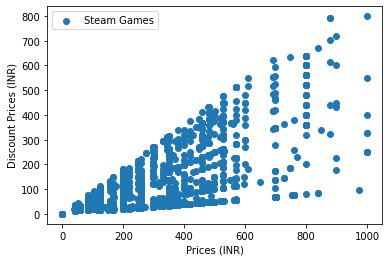

In [5]:
plt.scatter(df['price'], df['dc_price'], label='Steam Games')
plt.xlabel('Prices (INR)')
plt.ylabel('Discount Prices (INR)')
plt.legend()
plt.show()

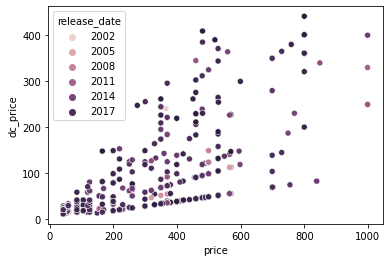

In [6]:
df_merged = pd.merge(df, df_cat, left_index=True, right_index=True, indicator=True)
df_filtered = df_merged[df_merged['_merge'] == 'both'].drop(columns='_merge').reset_index(drop=True)
sns.scatterplot(x='price', y='dc_price', hue='release_date', data=df_filtered)
plt.show()

# Create Model

In [7]:
X = df[['price']]
y = df['dc_price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
pipeline_workflow = create_pipeline(model=LinearRegression(fit_intercept=False))
pipeline_workflow.fit(X_train, y_train)
set_config(display='diagram')

In [8]:
pipeline_workflow

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6700e24c70>),
                                                 ('cat_transformer',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6700e24ac0>)])),
                ('linearregression', LinearRegression(fit_intercept=False))])

In [9]:
print(f"score de prédiction: {pipeline_workflow.score(X_test, y_test)}")
print(f"cross val score: {cross_val_score(pipeline_workflow, X_train, y_train, cv=6, scoring='r2').mean()}")

score de prédiction: 0.6722914724752176
cross val score: 0.6805156687135258


# Graphic

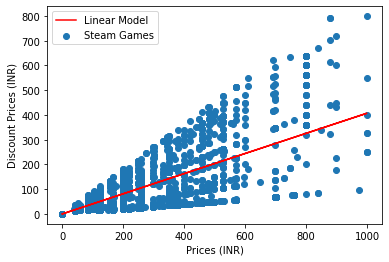

In [10]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)  # Add a column of 1s to X
model = sm.OLS(y_train, X_train).fit()

# Get the a and b parameters
a = model.params[1]
b = model.params[0]

lin,_ = plt.plot(X_train, a * X_train + b, c='r', label='Linear Model')
scat = plt.scatter(df['price'], df['dc_price'], label='Steam Games')
plt.xlabel('Prices (INR)')
plt.ylabel('Discount Prices (INR)')
plt.legend(handles=[lin, scat])
plt.show()

# Pickle the model

In [11]:
import pickle
pickle.dump(pipeline_workflow, open('pipeline.pkl', 'wb'))

In [12]:
pickled_model = pickle.load(open('pipeline.pkl', 'rb'))
pickled_model.score(X_test, y_test)

0.6722914724752176

# API

In [13]:
# !uvicorn Linreg:app --reload

INFO:     Will watch for changes in these directories: ['/root/Simplon_Projects/BriefProject']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [1404] using watchgod
INFO:     Started server process [1406]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     127.0.0.1:32978 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:32984 - "GET /?price=1000 HTTP/1.1" 200 OK
INFO:     127.0.0.1:32986 - "GET /?price=100 HTTP/1.1" 200 OK
INFO:     127.0.0.1:32988 - "GET /?price=0 HTTP/1.1" 200 OK
INFO:     127.0.0.1:32990 - "GET /?price=1 HTTP/1.1" 200 OK
^C
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [1406]
